### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore

###  Import the Dataset

In [13]:
df=pd.read_csv("water_dataX.csv",encoding= 'unicode_escape')

In [14]:
df.head()

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [15]:
df.shape

(1991, 12)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   STATION CODE                      1991 non-null   object
 1   LOCATIONS                         1991 non-null   object
 2   STATE                             1991 non-null   object
 3   Temp                              1991 non-null   object
 4   D.O. (mg/l)                       1991 non-null   object
 5   PH                                1991 non-null   object
 6   CONDUCTIVITY (µmhos/cm)           1991 non-null   object
 7   B.O.D. (mg/l)                     1991 non-null   object
 8   NITRATENAN N+ NITRITENANN (mg/l)  1991 non-null   object
 9   FECAL COLIFORM (MPN/100ml)        1991 non-null   object
 10  TOTAL COLIFORM (MPN/100ml)Mean    1991 non-null   object
 11  year                              1991 non-null   int64 
dtypes: int64(1), object(

In [17]:
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (µmhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [18]:
df = df.rename(columns={"D.O. (mg/l)": "DO", "CONDUCTIVITY (µmhos/cm)": "Conductivity", "B.O.D. (mg/l)": "BOD", "NITRATENAN N+ NITRITENANN (mg/l)": "NI", "FECAL COLIFORM (MPN/100ml)": "Fec_col", "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})

### Converting object into numeric

In [19]:
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 3
    for index in range(3, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

In [20]:
df = convert_to_numeric(df)
df.dtypes

STATION CODE     object
LOCATIONS        object
STATE            object
Temp            float64
DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
year              int64
dtype: object

###  Handling Missing values

Replacing string NAN values with actual NAN value (np.nan)

In [22]:
df.isnull().sum()

STATION CODE      0
LOCATIONS         0
STATE             0
Temp             92
DO               31
PH                8
Conductivity     25
BOD              43
NI              225
Fec_col         316
Tot_col         132
year              0
dtype: int64

In [21]:
def convert_to_nan(df):
    n_col = df.shape[1]
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

In [23]:
df = convert_to_nan(df)

In [25]:
df.isnull().sum().sort_values()

year              0
PH                8
Conductivity     25
DO               31
BOD              43
Temp             92
STATION CODE    122
Tot_col         132
LOCATIONS       184
NI              225
Fec_col         316
STATE           761
dtype: int64

Since I have 1900 training examples, I can replace each missing value with median of the column (to avoid outliers)

- Replacing NULL values with median of column
- Selecting numeric data

In [26]:
df_num = df.select_dtypes(exclude="object")
df_num_col = df_num.columns
imputer = SimpleImputer(strategy="median")

df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

 Filling Categorical missing values

In [27]:
df_cat = df.select_dtypes(include="object")
df_cat.isnull().sum()

STATION CODE    122
LOCATIONS       184
STATE           761
dtype: int64

Station Code with value 1330 will have Location
- TAMBIRAPARANI which belongs in STATE - TAMIL NADU
- I can replace all the NAN occurences in STATE with TAMILNADU

In [28]:
pd.set_option('mode.chained_assignment', None)
df_cat_copy = df_cat.copy()

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]
df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"] = df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


- The NULL values in LOCATION attribute are in STATE attribute (ex - above dataframe)
- So, I will fill the NULL values in LOCATION attribute with the corresponding STATE value
- And, the state value will be replaced by the function "fill_state" defined below this cell

In [30]:
def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()]
    location_null_indices = location_null.index
    for index in location_null_indices:
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

In [31]:
fill_locations(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [32]:
fill_locations(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [33]:
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


Now I can fill NULL values of Station code with corresponding LOCATION value(ex - above dataframe)
- I will match the corresponding LOCATION value with other same LOCATION value and insert the value of station code

In [34]:
def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_cat_copy)
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


Filling all state NAN values which have corresponding station code value

In [35]:
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [36]:
df_cat_copy.isnull().sum()

STATION CODE     5
LOCATIONS        3
STATE           13
dtype: int64

In [37]:
df_cat_copy[df_cat_copy["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


- The above are the missing values which are left and does not satisfy any condition
- So, according to the location these values will be filled manually

The first location KABBANI AT MUTHANKARA is in STATE Kerela

In [38]:
df_cat_copy["STATE"][1106] = "KERALA"
df_cat_copy["STATE"][1107] = "KERALA"
df_cat_copy["STATE"][1650] = "CHANDIGARH"
df_cat_copy["STATE"][1651] = "CHANDIGARH"
df_cat_copy["STATE"][1652] = "CHANDIGARH"
df_cat_copy["STATE"][1770] = "CHANDIGARH"
df_cat_copy["STATE"][1771] = "CHANDIGARH"
df_cat_copy["STATE"][1772] = "CHANDIGARH"
df_cat_copy["STATE"][1784] = "DAMAN & DIU"
df_cat_copy["STATE"][1785] = "DAMAN & DIU"
df_cat_copy["STATION CODE"][1784] = "0000"
df_cat_copy["STATION CODE"][1785] = "0000"

In [39]:
df_cat = df_cat_copy
df_cat.isnull().sum()

STATION CODE    3
LOCATIONS       3
STATE           3
dtype: int64

In [40]:
df_num.isnull().sum()

Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [41]:
df_final = pd.concat([df_cat, df_num], axis=1)
df_final.isnull().sum()

STATION CODE    3
LOCATIONS       3
STATE           3
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

- These are the samples which don't contain any attribute
- The filled attributes are median of corresponding columns
- So it is best to remove them

In [42]:
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
260,NaN,NaN,NaN,27.0,6.7,7.3,183.0,1.8965,0.516,221.0,468.0,2013.0
431,NaN,NaN,NaN,27.0,6.7,7.3,183.0,1.8965,0.516,221.0,468.0,2013.0
1912,NaN,NaN,NaN,27.0,6.7,7.3,183.0,1.8965,0.516,221.0,468.0,2003.0


In [44]:
df_final.isnull().sum()

STATION CODE    0
LOCATIONS       0
STATE           0
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [45]:
df_final.shape

(1988, 12)

The final dataset contains 1898 samples and 12 attributes

Plotting PDFs of all the numeric attributes in the dataset

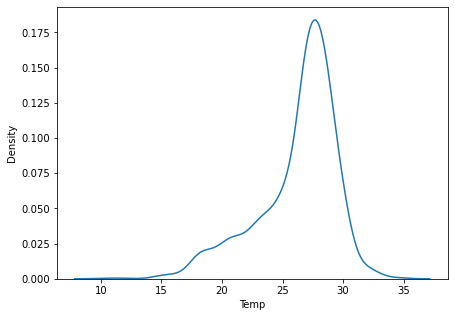

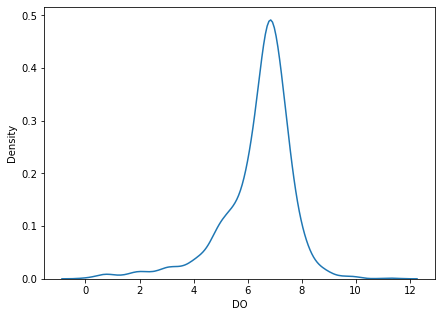

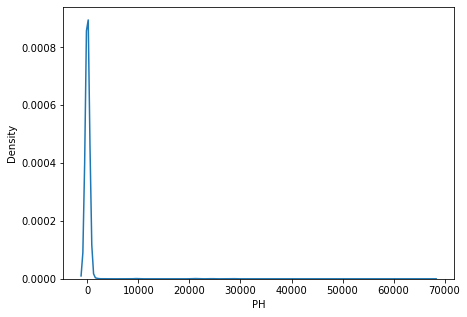

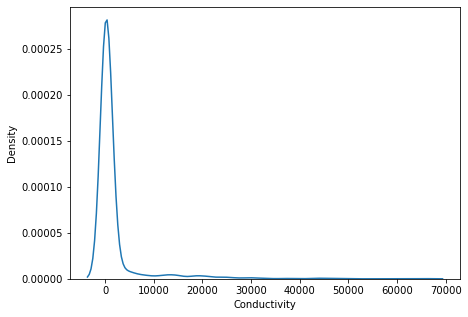

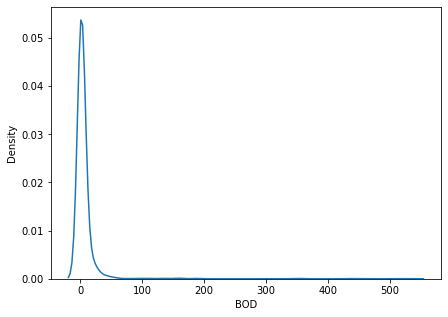

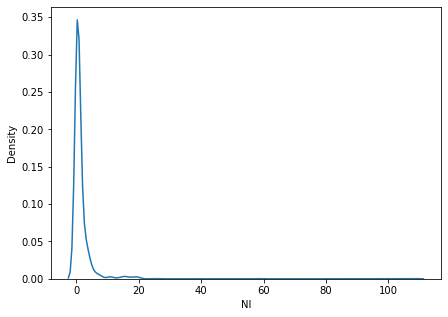

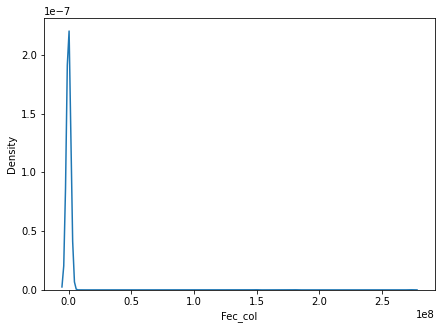

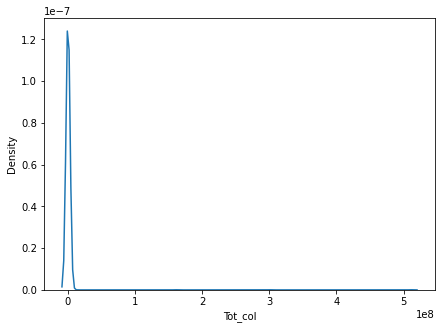

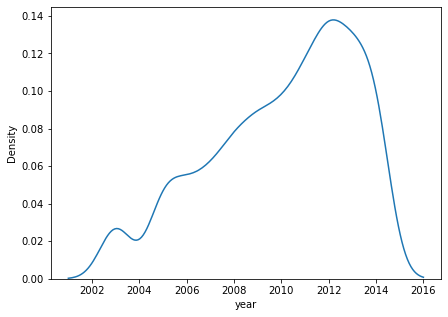

In [46]:
df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

### Outliers detection

- Using Z-Score Normalization to detect outliers

In [47]:
df_num_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
df_final.iloc[indices_arr, :]

Number of outliers using Z-Score method- 139


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,0.516,221.0,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,0.516,221.0,41.0,2012.0
1917,1862,RIVER KAVERI ON BRIDGE AT BILLIMORANANVALSAD ROAD,GUJARAT,29.0,8.1,467.0,7.1,3.0,0.516,221.0,107.0,2003.0
1924,1438,"MINDHOLA AT STATE HIGHWAY BRIDGE SACHIN, GUJARAT",GUJARAT,28.0,8.0,590.0,4.8,1.8,0.516,221.0,2873.0,2003.0
1925,1444,"KALI AT D/S WEST COAST PAPER MILL, KARNATAKA",KARNATAKA,27.0,7.7,440.0,6.5,2.4,0.900,0.9,688.0,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.000,1328.0,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.080,1400.0,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.900,272521616.0,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.000,1328.0,4975.0,2013.0


Number of outliers using Z-Score method- 125

In [48]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1862, 12)

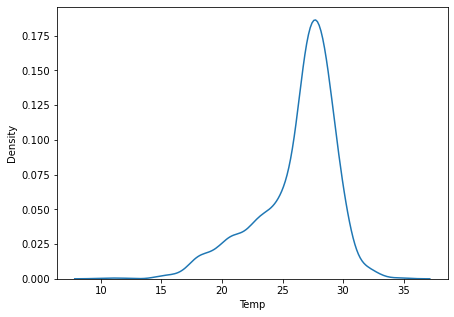

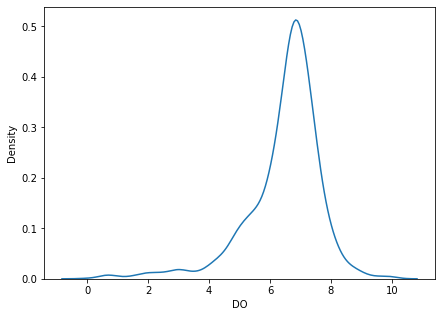

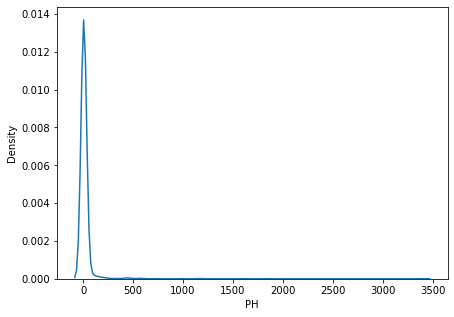

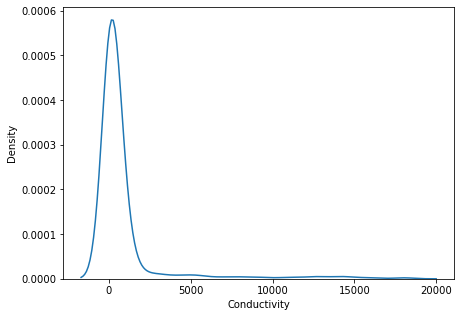

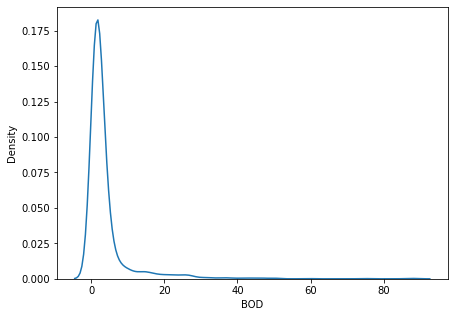

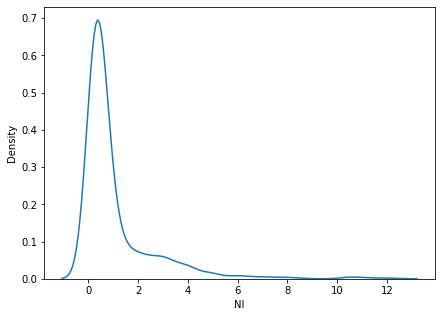

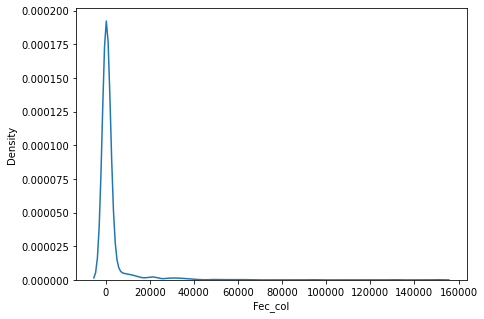

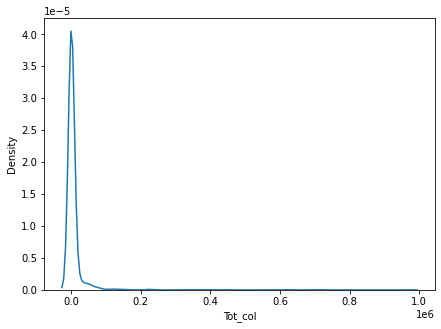

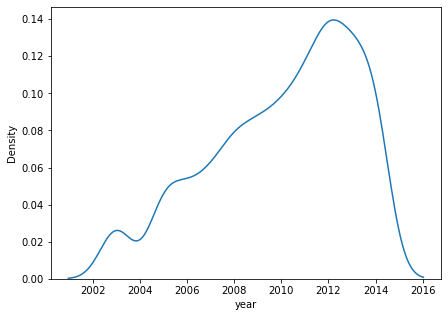

In [49]:
plot_kde(df_final.select_dtypes(exclude="object"))

### Water Quality Index Calculation

I will be using "Weighted Arithmetic Water Quality Index Method" to calculate WQI of each water sample. The formula to calculate WQI is -

#### WQI = ∑ qi × wi / ∑ wi

- Here wi - Unit weight of ith parameter

- qi - Quality estimate scale of each parameter, it is calculated with the formula - 

#### qi = 100 × ( Vi − VIdeal / Si − VIdeal )

Here Vi - Measured value of ith parameter

- Videal - Ideal value of ith parameter in pure water

- Si - Standard value recommended for ith parameter

wi is calculated by the formula -

#### wi = K / Si

Here K is proportionality constant which is -

#### K = 1 / ∑ Si

##### Standard value recommended for parameters (Si) -

Dissolved oxygen, mg/L 10

pH 8.5

Conductivity, µS/cm 1000

Biological oxygen demand, mg/L 5

Nitrate, mg/L 45

Fecal coliform/100 mL 100

Total coliform/100 mL 1000

##### Values of unit weights for each parameter (wi) -
Dissolved Oxygen 0.2213

pH 0.2604

Conductivity 0.0022

Biological Oxygen Demand 0.4426

Nitrate 0.0492

Fecal Coliform 0.0221

Total Coliform 0.0022

##### Ideal value of parameters (Videal) -
Dissolved Oxygen 14.6

pH 7.0

Conductivity 0

Biological Oxygen Demand 0

Nitrate 0

Fecal Coliform 0

Total Coliform 0

 #### Calculating Water Quality Index of each sample

In [53]:
df_num_final = df_final.select_dtypes(exclude="object")

Dropping year and Temp attribute because they are not used for computing WQI

In [54]:
df_num_final.drop(["year", "Temp"], axis=1, inplace=True)

Weight Vector(wi)

In [55]:
wi = np.array([0.2213, 0.2604, 0.0022, 0.4426, 0.0492, 0.0221, 0.0022])

 Standard values of parameters(si)

In [56]:
si = np.array([10, 8.5, 1000, 5, 45, 100, 1000])

Ideal values of paramters(vIdeal)

In [57]:
vIdeal = np.array([14.6, 7, 0, 0, 0, 0, 0])

In [59]:
def calc_wqi(sample):
    wqi_sample = 0
    num_col = 7
    for index in range(num_col):
        v_index = sample[index] # Obeserved value of sample at index
        v_index_ideal = vIdeal[index] # Ideal value of obeserved value
        w_index = wi[index] # weight of corresponding parameter of obeserved value
        std_index = si[index] # Standard value recommended for obeserved value
        q_index = (v_index - v_index_ideal) / (std_index - v_index_ideal)
        q_index = q_index * 100 # Final qi value of obeserved value
        wqi_sample += q_index*w_index
    return wqi_sample

Computing WQI for the whole dataset

In [60]:
def calc_wqi_for_df(df):
    wqi_arr = []
    for index in range(df.shape[0]):
        index_row = df.iloc[index, :]
        wqi_row = calc_wqi(index_row)
        wqi_arr.append(wqi_row)
    return wqi_arr

In [61]:
wqi_arr = calc_wqi_for_df(df_num_final)
# Converting oridnary array to numpy array
wqi_arr = np.array(wqi_arr)
wqi_arr = np.reshape(wqi_arr, (-1, 1))

Resetting index values of the dataframes

In [62]:
wqi_arr_df = pd.DataFrame(wqi_arr, columns=["WQI"]).reset_index()
df_final = df_final.reset_index()

Combining dataframe of WQI and dataframe of attributes

In [63]:
df_wqi = pd.concat([df_final, pd.DataFrame(wqi_arr, columns=["WQI"])], axis=1)
df_wqi.drop("index", axis=1, inplace=True)
df_wqi.shape

(1862, 13)

In [64]:
df_wqi[(df_wqi["WQI"] < 0)]

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI
196,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,20.5,6.7,2.7,1350.0,3.3000,1.100,7.0,16.0,2014.0,-6.855044
231,2,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,27.0,6.7,0.0,208.0,1.8965,0.516,221.0,468.0,2013.0,-61.637076
234,1865,RIVER DHADAR AT KOTHADA,GUJARAT,27.0,6.7,0.0,506.0,1.8965,6.000,26.0,227.0,2013.0,-65.334452
445,3375,LUKHA RIVER,MEGHALAYA,21.3,6.8,2.7,1074.0,3.2000,2.330,4.0,11.0,2013.0,-8.214971
718,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,25.0,6.9,2.6,1072.0,3.2000,1.170,3.0,21.0,2012.0,-10.579224


In [65]:
df_neg_indices = df_wqi[(df_wqi["WQI"] < 0)].index
df_wqi.drop(df_neg_indices, axis=0, inplace=True)

In [66]:
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: (3 if (x <= 25)  
                                        else(2 if (26<=x<=50) 
                                        else(1 if (51<=x<=75) 
                                        else 0))))

In [67]:
df_wqi.tail()

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
1857,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,7.9,738.0,7.2,2.7,0.518,0.518,202.0,2003.0,12746.407333,0
1858,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,29.0,7.5,585.0,6.3,2.6,0.155,0.155,315.0,2003.0,10091.343432,0
1859,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,7.6,98.0,6.2,1.2,0.516,221.000,570.0,2003.0,1629.125767,0
1860,1404,"GUMTI AT D/S SOUTH TRIPURA, TRIPURA",TRIPURA,28.0,7.7,91.0,6.5,1.3,0.516,221.000,562.0,2003.0,1508.008186,0
1861,1726,"CHANDRAPUR, AGARTALA D/S OF HAORA RIVER, TRIPURA",TRIPURA,29.0,7.6,110.0,5.7,1.1,0.516,221.000,546.0,2003.0,1836.555177,0


In [68]:
df_wqi.describe()

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
count,1857.000000,1857.00000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000
mean,26.249024,6.46968,21.444437,914.469160,3.904589,1.088036,2163.068225,6992.528810,2010.059774,374.095071,0.684976
std,3.235525,1.24775,125.862427,2557.465581,7.002613,1.576473,8095.718660,39406.757235,3.044247,2189.980440,0.730608
min,10.000000,0.00000,2.900000,3.700000,0.100000,0.000000,0.000000,0.000000,2003.000000,16.795814,0.000000
25%,25.000000,6.00000,6.900000,76.000000,1.100000,0.270000,38.000000,113.000000,2008.000000,55.271272,0.000000
50%,27.000000,6.70000,7.300000,169.000000,1.800000,0.516000,221.000000,468.000000,2011.000000,71.845041,1.000000
75%,28.200000,7.20000,7.700000,439.000000,3.400000,1.010000,590.000000,1630.000000,2013.000000,101.752648,1.000000
max,35.000000,10.00000,3384.000000,18291.000000,88.000000,12.150000,150250.000000,967500.000000,2014.000000,58680.748613,3.000000


In [80]:
df_wqi.to_csv('Clean_water_data.csv')

In [72]:
df_wqi["WQI"].value_counts()

48.500828      2
63.778321      1
53.494592      1
135.400788     1
93.189114      1
              ..
69.431542      1
66.359237      1
54.547025      1
55.203906      1
1836.555177    1
Name: WQI, Length: 1856, dtype: int64

In [74]:
df_wqi.isnull().sum()

STATION CODE    0
LOCATIONS       0
STATE           0
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
WQI             0
WQI clf         0
dtype: int64

In [75]:
df_wqi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1857 entries, 0 to 1861
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   STATION CODE  1857 non-null   object 
 1   LOCATIONS     1857 non-null   object 
 2   STATE         1857 non-null   object 
 3   Temp          1857 non-null   float64
 4   DO            1857 non-null   float64
 5   PH            1857 non-null   float64
 6   Conductivity  1857 non-null   float64
 7   BOD           1857 non-null   float64
 8   NI            1857 non-null   float64
 9   Fec_col       1857 non-null   float64
 10  Tot_col       1857 non-null   float64
 11  year          1857 non-null   float64
 12  WQI           1857 non-null   float64
 13  WQI clf       1857 non-null   int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 217.6+ KB


<AxesSubplot:>

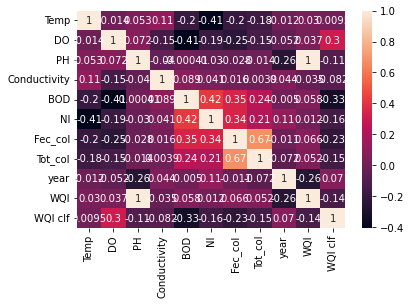

In [77]:
sns.heatmap(df_wqi.corr(),annot=True)

In [79]:
df_wqi.drop(['WQI','STATION CODE','LOCATIONS','STATE','Fec_col','Tot_col','year'],axis=1)

,Temp,DO,PH,Conductivity,BOD,NI,WQI clf
0,30.6,6.7,7.5,203.0,1.8965,0.100,1
1,29.8,5.7,7.2,189.0,2.0000,0.200,0
2,29.5,6.3,6.9,179.0,1.7000,0.100,0
3,29.7,5.8,6.9,64.0,3.8000,0.500,0
4,29.5,5.8,7.3,83.0,1.9000,0.400,0
...,...,...,...,...,...,...,...
1857,27.0,7.9,738.0,7.2,2.7000,0.518,0
1858,29.0,7.5,585.0,6.3,2.6000,0.155,0
1859,28.0,7.6,98.0,6.2,1.2000,0.516,0
1860,28.0,7.7,91.0,6.5,1.3000,0.516,0


In [ ]:
new_data